# Mapping Peak Annual Gage Height/Flow - Carnation
## Load from USGS
Source:
https://nwis.waterdata.usgs.gov/wa/nwis/peak?site_no=12149000&agency_cd=USGS&format=rdb

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

url = 'https://nwis.waterdata.usgs.gov/wa/nwis/peak?site_no=12149000&agency_cd=USGS&format=rdb'
df0 = pd.read_csv(url,comment='#',delimiter='\t')
df0 = df0.drop(0) # drop data type row
df0.head(5)

,agency_cd,site_no,peak_dt,peak_tm,peak_va,peak_cd,gage_ht,gage_ht_cd,year_last_pk,ag_dt,ag_tm,ag_gage_ht,ag_gage_ht_cd
1,USGS,12149000,1929-12-14,NaN,14800,NaN,7.62,3,NaN,NaN,NaN,NaN,NaN
2,USGS,12149000,1931-01-28,NaN,27400,NaN,10.51,3,NaN,NaN,NaN,NaN,NaN
3,USGS,12149000,1932-02-27,NaN,59500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USGS,12149000,1932-11-13,NaN,59000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,USGS,12149000,1933-11-03,NaN,48700,NaN,15.83,3,NaN,NaN,NaN,NaN,NaN


## Fix Up Data

In [11]:
# Calculate water year
df0['peak_dt'] = pd.to_datetime(df0['peak_dt'])
df0['water_year']=(df0['peak_dt'] + timedelta(days=92)).apply(lambda x: int(x.year))

# fix up datatypes
df0['gage_ht'] = df0['gage_ht'].apply(pd.to_numeric)
df0['peak_va'] = df0['peak_va'].apply(pd.to_numeric)

# Remove first 10 rows for Carnation. Gage hight changes to modern scale in 1940.
df = df0.loc[:,['water_year','peak_va','gage_ht']]
df.head(5)

,water_year,peak_va,gage_ht
1,1930,14800,7.62
2,1931,27400,10.51
3,1932,59500,NaN
4,1933,59000,NaN
5,1934,48700,15.83


## Add in 2016 

In [3]:
from datetime import date
df_2016 = pd.DataFrame([[2016,56200.0,59.78]], 
                       columns=['water_year','peak_va','gage_ht'])
df = df.append(df_2016, ignore_index=True)
df.tail(5)

,water_year,peak_va,gage_ht
82,2012,33100.0,57.12
83,2013,15100.0,52.26
84,2014,36400.0,56.55
85,2015,53900.0,59.24
86,2016,56200.0,59.78


## Mann_Kendall
From source: https://mail.scipy.org/pipermail/scipy-dev/2016-July/021413.html

>This function is derived from code originally posted by Sat Kumar Tomer (satkumartomer at gmail.com)
See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

>The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically 
assess if there is a monotonic upward or downward trend of the variable of interest over time. A 
monotonic upward (downward) trend means that the variable consistently increases (decreases) through 
time, but the trend may or may not be linear. The MK test can be used in place of a parametric linear 
regression analysis, which can be used to test if the slope of the estimated linear regression line 
is different from zero. The regression analysis requires that the residuals from the fitted regression 
line be normally distributed; an assumption not required by the MK test, that is, the MK test is a 
non-parametric (distribution-free) test.

>Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best viewed as an exploratory 
analysis and is most appropriately used to identify stations where changes are significant or of large 
magnitude and to quantify these findings.


In [4]:
from scipy import stats
from scipy.stats import norm

def mk_test(x, alpha = 0.05):
    """
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05)
    """
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
            z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

## Plot function

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

from pylab import rcParams
rcParams['figure.figsize'] = 10,5

def plot_data(x_data, y_data, x_label, y_label, point_label):
    plt.scatter(x_data,y_data,
                color='blue', marker='o', label=point_label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,y_data)

    def func(x, a, b):
        return a*x + b

    plt.plot(x_data, func(x_data, slope, intercept), 'r-', label='fit',color='green')

    plt.legend(loc='upper left')

    plt.show()

    over_10_years = round(slope*10,2);
    print('slope  ',slope, ' (', over_10_years, ' every 10 years)', sep="")
    print('p_value ', p_value)
    print('r_value ', r_value)
    print('std_err ', std_err)


    critical_value = 1.664 #http://stattrek.com/regression/slope-confidence-interval.aspx?Tutorial=AP
    conf_interval = critical_value * std_err
    conf_over_10_years = round(conf_interval*10,2)
    print('conv_interval ', conf_interval, ' (+/-',conf_over_10_years,' over 10 years - 90% conf, ',
          over_10_years - conf_over_10_years, ' - ', 
          over_10_years + conf_over_10_years, ')', sep="")
    #    Mann-Kendall Output:
    #        trend: tells the trend (increasing, decreasing or no trend)
    #        h: True (if trend is present) or False (if trend is absence)
    #        p: p value of the significance test
    #        z: normalized test statistics
    def display_mk_test(data, alpha):
        mk = mk_test(data,alpha)
        print('Mann-Kendall test: ', int(100*(1-alpha)),'%', sep='')
        print('  slope:', mk[0])
        print('      h:', 'Monotonic trend is present' if mk[1] else 'No monottonic trend')
        print('      p:', mk[2])
        print('      z:', mk[3])
        return mk
    s,h,p,z = display_mk_test(y_data.values,0.1)
    if h: s,h,p,z = display_mk_test(y_data.values,0.05)
    if h: s,h,p,z = display_mk_test(y_data.values,0.01)

## Plots
Scatter plot of water_year and gage measures with least-squares linear regression fit line. 
### Max Gage Height 
From 1940, the first year the gage height was set to the current datum (1929 NGVD), through 2016.

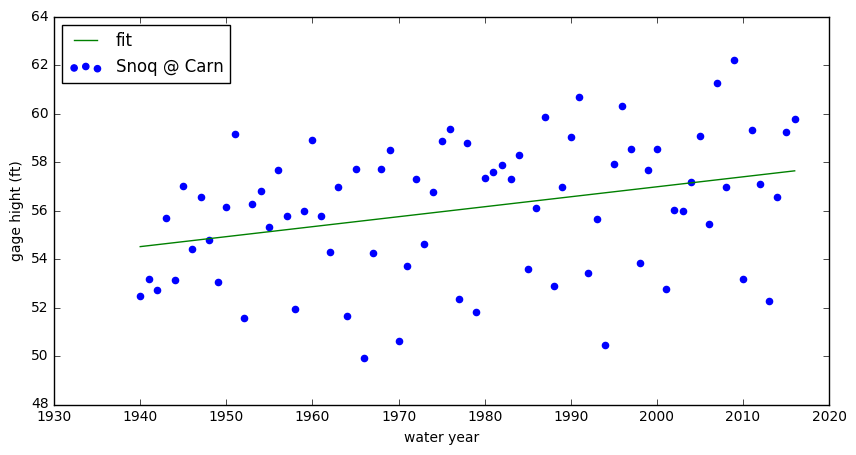

slope  0.0411756664388 (0.41 every 10 years)
p_value  0.00333151898932
r_value  0.330468767487
std_err  0.0135789862058
conv_interval 0.0225954330464 (+/-0.23 over 10 years - 90% conf, 0.18 - 0.64)
Mann-Kendall test: 90%
  slope: increasing
      h: Monotonic trend is present
      p: 0.00233812298688
      z: 3.04354007287
Mann-Kendall test: 95%
  slope: increasing
      h: Monotonic trend is present
      p: 0.00233812298688
      z: 3.04354007287
Mann-Kendall test: 99%
  slope: increasing
      h: Monotonic trend is present
      p: 0.00233812298688
      z: 3.04354007287


In [6]:
x_data = df[df['water_year']>=1940]['water_year']
y_data = df[df['water_year']>=1940]['gage_ht']
plot_data(x_data, y_data, 'water year', 'gage hight (ft)', 'Snoq @ Carn')

### Gage Flow (all data)
From 1930 through 2016.

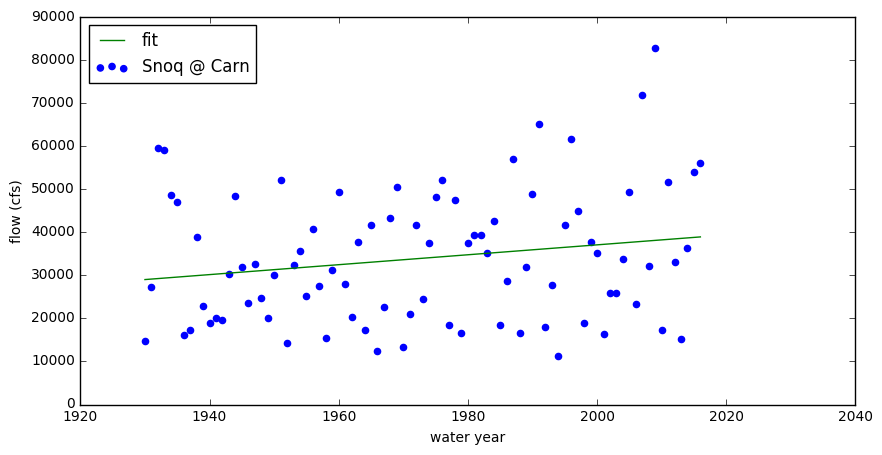

slope  115.189181308 (1151.89 every 10 years)
p_value  0.0767388261424
r_value  0.19076881463
std_err  64.2902151478
conv_interval 106.978918006 (+/-1069.79 over 10 years - 90% conf, 82.1 - 2221.68)
Mann-Kendall test: 90%
  slope: no trend
      h: No monottonic trend
      p: 0.116644403095
      z: 1.56901517512


In [7]:
x_data = df['water_year']
y_data = df['peak_va']

plot_data(x_data, y_data, 'water year', 'flow (cfs)', 'Snoq @ Carn')

### Gage Flow (1934 on)
From 1934 through 2016.

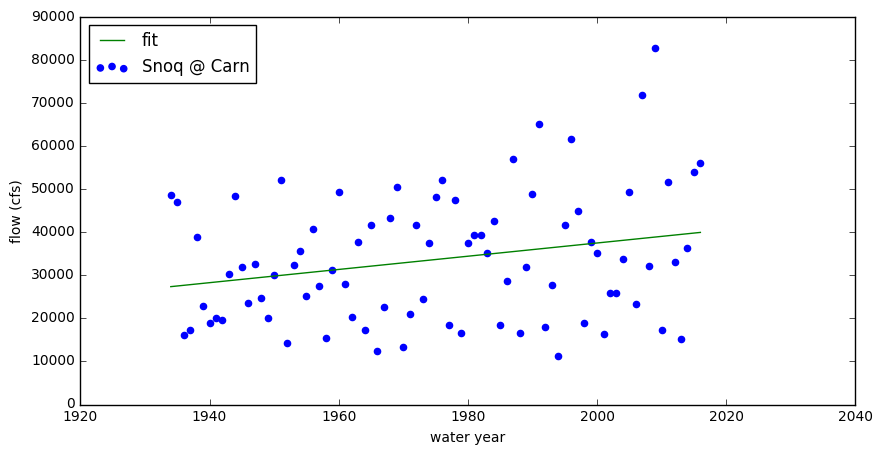

slope  153.593467948 (1535.93 every 10 years)
p_value  0.0239219745871
r_value  0.247768162819
std_err  66.7309859572
conv_interval 111.040360633 (+/-1110.4 over 10 years - 90% conf, 425.53 - 2646.33)
Mann-Kendall test: 90%
  slope: increasing
      h: Monotonic trend is present
      p: 0.0590777174887
      z: 1.88761453394
Mann-Kendall test: 95%
  slope: no trend
      h: No monottonic trend
      p: 0.0590777174887
      z: 1.88761453394


In [8]:
x_data = df[df['water_year']>=1934]['water_year']
y_data = df[df['water_year']>=1934]['peak_va']

plot_data(x_data, y_data, 'water year', 'flow (cfs)', 'Snoq @ Carn')

### Max Gage Flow (2 year buckets)

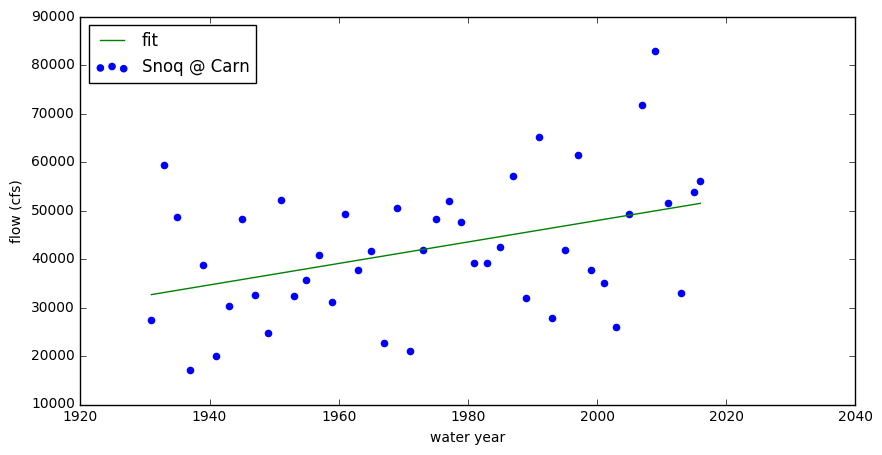

slope  221.605264025 (2216.05 every 10 years)
p_value  0.00696133015747
r_value  0.401147516399
std_err  78.0824043189
conv_interval 129.929120787 (+/-1299.29 over 10 years - 90% conf, 916.76 - 3515.34)
Mann-Kendall test: 90%
  slope: increasing
      h: Monotonic trend is present
      p: 0.0111436836149
      z: 2.53816059107
Mann-Kendall test: 95%
  slope: increasing
      h: Monotonic trend is present
      p: 0.0111436836149
      z: 2.53816059107
Mann-Kendall test: 99%
  slope: no trend
      h: No monottonic trend
      p: 0.0111436836149
      z: 2.53816059107


In [9]:
df['two_year'] = (df['water_year']/2).apply(int)*2
max = df.groupby('two_year').max()
x_data = max['water_year']
y_data = max['peak_va']

plot_data(x_data, y_data, 'water year', 'flow (cfs)', 'Snoq @ Carn')

## Data Table

In [10]:
df

,water_year,peak_va,gage_ht,two_year
0,1930,14800.0,7.62,1930
1,1931,27400.0,10.51,1930
2,1932,59500.0,NaN,1932
3,1933,59000.0,NaN,1932
4,1934,48700.0,15.83,1934
5,1935,47100.0,15.40,1934
6,1936,16100.0,NaN,1936
7,1937,17200.0,9.60,1936
8,1938,38800.0,14.57,1938
9,1939,22900.0,11.20,1938
